In [2]:
import argparse
from typing import List, Dict, Tuple, Optional
import json
import os
import sys
import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import numpy as np
import cv2
from helper_func import decode_rle_mask, load_image, draw_annotations_on_image


In [90]:
coco_instance_result_file = 'predict.json'
annotation_file = '../../coco_kvasirseg/val/annotations/val.json'
image_path = '../../coco_kvasirseg/val/images/'
output_dir = 'evaluation/try/visualizations/'
num_images = 10
tasks = ['segmentation']
acceptance_threshold = 0.9


In [8]:
def load_data(coco_instance_result_file: str, annotation_file: str) -> Tuple[Dict, Dict, Dict]:
    """
    Load predictions, images, and annotations from COCO format files.

    Args:
        coco_instance_result_file: Path to COCO format predictions JSON file
        annotation_file: Path to COCO format ground truth annotations JSON file

    Returns:
        Tuple of (image_info_dict, annotation_dict, prediction_dict)
        - image_info_dict: dict mapping image_id to image info
        - annotation_dict: dict mapping image_id to list of annotations
        - prediction_dict: dict mapping image_id to list of predictions
    """
    if not os.path.exists(coco_instance_result_file):
        raise FileNotFoundError(f"Predictions file not found: {coco_instance_result_file}")
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")

    # Load predictions
    prediction_dict = {}
    with open(coco_instance_result_file, 'r') as f:
        predictions = json.load(f)
    
    for prediction in predictions:
        image_id = prediction['image_id']
        if image_id not in prediction_dict:
            prediction_dict[image_id] = []
        prediction_dict[image_id].append(prediction)

    # Load ground truth annotations
    image_info_dict = {}
    annotation_dict = {}
    
    with open(annotation_file, 'r') as f:
        ground_truth = json.load(f)
        images = ground_truth.get('images', [])
        annotations = ground_truth.get('annotations', [])
        
        # Build image info dictionary
        for image in images:
            image_info_dict[image['id']] = image
        
        # Build annotation dictionary
        for annotation in annotations:
            img_id = annotation['image_id']
            if img_id not in annotation_dict:
                annotation_dict[img_id] = []
            annotation_dict[img_id].append(annotation)
    
    return image_info_dict, annotation_dict, prediction_dict


In [9]:
image_info_dict, annotation_dict, prediction_dict = load_data(coco_instance_result_file, annotation_file)

In [14]:
def extract_tp_fp_fn_from_cocoeval(coco_eval: COCOeval, iou_thresh: float = 0.5) -> Dict[str, int]:
    """
    Extract TP, FP, FN counts from COCOeval object.
    
    This function extracts true positives, false positives, and false negatives
    from the COCOeval evaluation results at a specific IoU threshold.
    
    Args:
        coco_eval: COCOeval object after evaluate() has been called
        iou_thresh: IoU threshold to use for matching (default: 0.5)
    
    Returns:
        Dictionary with 'tp', 'fp', 'fn' counts
    """
    # # Find the index of the IoU threshold closest to iou_thresh
    # iou_thresh_idx = np.argmin(np.abs(coco_eval.params.iouThrs - iou_thresh))
    
    # # Get matches at this IoU threshold
    # # dtMatches shape: [T, R, K, A, M] where:
    # #   T = IoU thresholds, R = recall thresholds, K = classes, A = areas, M = max dets
    # dtMatches = coco_eval.eval['dtMatches'][iou_thresh_idx]  # [R, K, A, M]
    # gtMatches = coco_eval.eval['gtMatches'][iou_thresh_idx]  # [R, K, A, M]
    
    # # Use the last recall threshold (most permissive) and last max_det setting
    # recall_idx = -1
    # max_det_idx = -1  # Use maximum detections setting
    
    # tp = 0
    # fp = 0
    # fn = 0
    
    # # Iterate over all classes and areas
    # for class_idx in range(dtMatches.shape[1]):  # K classes
    #     for area_idx in range(dtMatches.shape[2]):  # A areas
    #         # Get matches for this class/area combination
    #         dt_matches = dtMatches[recall_idx, class_idx, area_idx, max_det_idx]
    #         gt_matches = gtMatches[recall_idx, class_idx, area_idx, max_det_idx]
            
    #         # TP: number of detections that matched (non-zero values in dtMatches)
    #         tp += np.sum(dt_matches > 0)
            
    #         # FP: number of detections that didn't match
    #         fp += np.sum(dt_matches == 0)
            
    #         # FN: number of ground truths that didn't match
    #         fn += np.sum(gt_matches == 0)
    
    # return {
    #     'tp': int(tp),
    #     'fp': int(fp),
    #     'fn': int(fn)
    # }
    pass

def compute_ap_scores(coco_instance_result_file: str, annotation_file: str, 
                      iou_type: str = 'bbox') -> Tuple[Dict[str, float], COCOeval]:
    """
    Compute AP (Average Precision) scores using COCO evaluation API.
    
    Args:
        coco_instance_result_file: Path to predictions JSON file
        annotation_file: Path to ground truth annotations JSON file
        iou_type: Type of IoU to use ('bbox' or 'segm')
    
    Returns:
        Tuple of (ap_scores dict, coco_eval object for PR curve)
    """
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f"Annotation file not found: {annotation_file}")
    if not os.path.exists(coco_instance_result_file):
        raise FileNotFoundError(f"Predictions file not found: {coco_instance_result_file}")
    
    # Load ground truth
    coco_gt = COCO(annotation_file)
    
    # Load predictions
    with open(coco_instance_result_file, 'r') as f:
        predictions = json.load(f)
    
    coco_dt = coco_gt.loadRes(predictions)
    
    # Run COCO evaluation
    coco_eval = COCOeval(coco_gt, coco_dt, iou_type)
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    
    # Extract AP scores
    ap_scores = {
        'AP': coco_eval.stats[0],      # AP @ IoU=0.50:0.95
        'AP50': coco_eval.stats[1],    # AP @ IoU=0.50
        'AP75': coco_eval.stats[2],    # AP @ IoU=0.75
        'AP_small': coco_eval.stats[3], # AP for small objects
        'AP_medium': coco_eval.stats[4], # AP for medium objects
        'AP_large': coco_eval.stats[5],  # AP for large objects
        'AR_1': coco_eval.stats[6],     # AR given 1 det per image
        'AR_10': coco_eval.stats[7],   # AR given 10 dets per image
        'AR_100': coco_eval.stats[8],  # AR given 100 dets per image
    }
    
    # # Extract TP, FP, FN at IoU=0.5
    # tp_fp_fn = extract_tp_fp_fn_from_cocoeval(coco_eval, iou_thresh=0.5)
    # ap_scores.update(tp_fp_fn)
    
    return ap_scores, coco_eval


In [15]:
ap_scores, coco_eval = compute_ap_scores(coco_instance_result_file, annotation_file)
print(ap_scores)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.12s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.702
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.888
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.774
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.634
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.711
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.682
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.833
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

In [ ]:
def _compute_bbox_iou(bbox1: List[float], bbox2: List[float]) -> float:
    """Compute IoU between two bounding boxes in COCO format [x, y, w, h]."""
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
    
    # Convert to (x1, y1, x2, y2) format
    box1 = [x1, y1, x1 + w1, y1 + h1]
    box2 = [x2, y2, x2 + w2, y2 + h2]
    
    # Calculate intersection
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    # Calculate union
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    
    return inter_area / union_area if union_area > 0 else 0.0


In [24]:
def plot_pr_curve(coco_eval: COCOeval, output_dir: str) -> None:
    """
    Plot Precision-Recall curve from COCO evaluation results.
    
    Args:
        coco_eval: COCO evaluation object after evaluate() and accumulate()
        output_dir: Directory to save the plot
        iou_type: Type of evaluation ('bbox' or 'segm')
    """
    iouType = coco_eval.params.iouType if coco_eval.params.iouType else ''

    os.makedirs(output_dir, exist_ok=True)
    
    # Get precision and recall arrays
    precision = coco_eval.eval['precision']
    recall = coco_eval.params.recThrs
    
    # Average precision over all classes and IoU thresholds
    # precision shape: [T, R, K, A, M] where T=IoU thresholds, R=recall thresholds, K=classes, A=area, M=max dets
    # We average over classes (K), areas (A), and max dets (M)
    precision_mean = precision[:, :, :, :, :].mean(axis=(2, 3, 4))  # Average over K, A, M
    
    plt.figure(figsize=(10, 6))
    for i, iou_thresh in enumerate(coco_eval.params.iouThrs):
        plt.plot(recall, precision_mean[i, :], 
                label=f'IoU={iou_thresh:.2f}', linewidth=2)
    
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title(f'Precision-Recall Curve ({iouType.upper()})', fontsize=14, fontweight='bold')
    plt.legend(loc='lower left', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
    output_path = os.path.join(output_dir, f'pr_curve_{iouType}.png')
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"PR curve saved to: {output_path}")


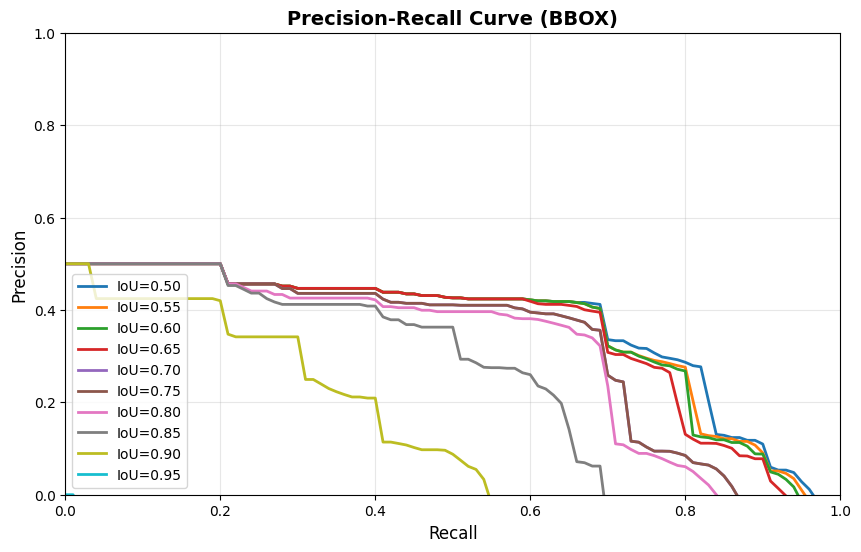

PR curve saved to: evaluation/kvasirseg/visualizations/pr_curve_bbox.png


In [25]:
plot_pr_curve(coco_eval, output_dir)

In [26]:
# def _plot_segmentation_analysis(image_path: str, image_info: Dict, 
#                                 anno_mask: np.ndarray, pred_mask: np.ndarray,
#                                 tp: int, fp: int, fn: int, plot_dir: str) -> None:
#     """Create visualization for segmentation analysis."""
#     os.makedirs(plot_dir, exist_ok=True)
    
#     # Load image
#     full_image_path = os.path.join(image_path, image_info['file_name'])
#     if not os.path.exists(full_image_path):
#         print(f"Image not found: {full_image_path}")
#         return
    
#     img = load_image(full_image_path)
    
#     # Create comparison mask: white=TP, yellow=FP, red=FN
#     h, w = anno_mask.shape
#     comparison = np.zeros((h, w, 3), dtype=np.uint8)
#     comparison[anno_mask & pred_mask] = [255, 255, 255]  # TP: white
#     comparison[pred_mask & ~anno_mask] = [255, 255, 0]   # FP: yellow
#     comparison[anno_mask & ~pred_mask] = [255, 0, 0]     # FN: red
    
#     # Create figure
#     fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
#     # Original image
#     axes[0].imshow(img)
#     axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
#     axes[0].axis('off')
    
#     # Ground truth mask
#     axes[1].imshow(anno_mask, cmap='gray')
#     axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
#     axes[1].axis('off')
    
#     # Prediction mask
#     axes[2].imshow(pred_mask, cmap='gray')
#     axes[2].set_title('Predictions', fontsize=12, fontweight='bold')
#     axes[2].axis('off')
    
#     # Comparison overlay
#     axes[3].imshow(img)
#     axes[3].imshow(comparison, alpha=0.5)
#     axes[3].set_title(f'Comparison (TP:{tp}, FP:{fp}, FN:{fn})', fontsize=12, fontweight='bold')
#     axes[3].axis('off')
    
#     plt.tight_layout()
#     output_path = os.path.join(plot_dir, f"seg_{image_info['id']}.png")
#     plt.savefig(output_path, dpi=150, bbox_inches='tight')
#     plt.close()


# def _plot_bbox_analysis(image_path: str, image_info: Dict,
#                         annos: List[Dict], preds: List[Dict],
#                         matched_preds: set, matched_annos: set,
#                         plot_dir: str) -> None:
#     """Create visualization for bbox analysis."""
#     os.makedirs(plot_dir, exist_ok=True)
    
#     # Load image
#     full_image_path = os.path.join(image_path, image_info['file_name'])
#     if not os.path.exists(full_image_path):
#         print(f"Warning: Image not found: {full_image_path}")
#         return
    
#     img = load_image(full_image_path)
    
#     # Create visualization
#     fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
#     # Ground truth
#     gt_img = draw_annotations_on_image(img.copy(), annos, color=(0, 255, 0))
#     axes[0].imshow(gt_img)
#     axes[0].set_title(f'Ground Truth ({len(annos)} boxes)', fontsize=12, fontweight='bold')
#     axes[0].axis('off')
    
#     # Predictions
#     pred_img = draw_annotations_on_image(img.copy(), preds, color=(255, 0, 0), show_scores=True)
#     axes[1].imshow(pred_img)
#     axes[1].set_title(f'Predictions ({len(preds)} boxes)', fontsize=12, fontweight='bold')
#     axes[1].axis('off')
    
#     # Combined (green=GT, red=pred, blue=matched)
#     combined_img = img.copy()
#     for i, pred in enumerate(preds):
#         if i in matched_preds:
#             color = (0, 0, 255)  # Blue for matched
#         else:
#             color = (255, 0, 0)  # Red for unmatched
#         if 'bbox' in pred:
#             combined_img = draw_annotations_on_image(combined_img, [pred], color=color)
    
#     for j, anno in enumerate(annos):
#         if j not in matched_annos:
#             if 'bbox' in anno:
#                 combined_img = draw_annotations_on_image(combined_img, [anno], color=(0, 255, 0))
    
#     axes[2].imshow(combined_img)
#     axes[2].set_title(f'Combined (TP:{len(matched_preds)})', fontsize=12, fontweight='bold')
#     axes[2].axis('off')
    
#     plt.tight_layout()
#     output_path = os.path.join(plot_dir, f"bbox_{image_info['id']}.png")
#     plt.savefig(output_path, dpi=150, bbox_inches='tight')
#     plt.close()


Print the macro average for metrics

In [49]:
score_threshold_acceptance = 0.5 ## minimum score threshold for predictions
iou_threshold_acceptance = 0.5 ## minimum iou threshold for matching predictions to ground truth

In [120]:
## assign the predictions to the ground truth
## then compute the metrics on each pair
from typing import List, Dict, Tuple, Any
def _compute_iou(predBox: List[float], annoBox: List[float]) -> float:
    x1, y1, w1, h1 = predBox
    x2, y2, w2, h2 = annoBox

    inter_area = max(0, min(x1 + w1, x2 + w2) - max(x1, x2)) * max(0, min(y1 + h1, y2 + h2) - max(y1, y2))
    union_area = w1 * h1 + w2 * h2 - inter_area
    return inter_area / union_area

def compute_metrics(pred_mask: np.ndarray, anno_mask: np.ndarray) -> Dict[str, float]:
    ## compute tp, fp, fn, tn for each pixel
    if pred_mask is None or anno_mask is None:
        return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'dice': 0.0, 'jaccard': 0.0}
    tp = np.sum(pred_mask & anno_mask)
    fp = np.sum(pred_mask & ~anno_mask)
    fn = np.sum(anno_mask & ~pred_mask)
    tn = np.sum(~pred_mask & ~anno_mask)
    
    ## compute precision, recall, f1, dice, jaccard
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
    jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    return {'precision': precision, 'recall': recall, 'f1': f1, 'dice': dice, 'jaccard': jaccard}

def assign_predictions_to_ground_truth(preds: List[Dict[str, Any]], annos: List[Dict[str, Any]], threshold: float = 0.5) -> List[Tuple[Dict[str, Any], Dict[str, Any]]]:
    if len(preds) == 0 or len(annos) == 0:
        # print("No predictions or ground truth found")
        return []
    pred_bboxs = [pred['bbox'] for pred in preds]
    anno_bboxs = [anno['bbox'] for anno in annos]

    iou_matrix = np.zeros((len(pred_bboxs), len(anno_bboxs)))

    for i, pred_bbox in enumerate(pred_bboxs):
        for j, anno_bbox in enumerate(anno_bboxs):
            iou_matrix[i, j] = _compute_iou(pred_bbox, anno_bbox)

    matching_gt_to_pred = [None] * len(annos)
    for i, anno in enumerate(annos):
        best_match = np.argmax(iou_matrix[:, i])
        if iou_matrix[best_match, i] >= threshold:
            matching_gt_to_pred[i] = best_match
            iou_matrix[best_match, :] = np.array([0.0] * iou_matrix.shape[1])
        else:
            matching_gt_to_pred[i] = -1
    
    prediction_pairs = []
    for i in range(len(annos)):
        if matching_gt_to_pred[i] == -1:
            prediction_pairs.append((None, annos[i]))
        else:
            prediction_pairs.append((preds[matching_gt_to_pred[i]], annos[i]))
    return prediction_pairs




In [135]:
## macro average: matching predictions to ground truth and compute average on metrics
def macro_average(preds, annos, score_threshold_acceptance, iou_threshold_acceptance):
    metrics_across_all = {}
    for index in annotation_dict.keys():
        annos = annotation_dict[index].copy()
        preds = prediction_dict[index].copy()
        preds = [pred for pred in preds if pred['score'] >= score_threshold_acceptance]
        prediction_pairs = assign_predictions_to_ground_truth(preds, annos, threshold=iou_threshold_acceptance)
        
        metrics = []
        for item in prediction_pairs:
            pred, anno = item

            pred_mask, anno_mask = None, None
            if pred is not None:
                pred_mask = np.array(decode_rle_mask(pred['segmentation']))
            if anno is not None:
                anno_mask = np.array(decode_rle_mask(anno['segmentation']))
            metrics.append(compute_metrics(pred_mask, anno_mask))

        if metrics:
            mean_metrics = {k: np.mean([m[k] for m in metrics]) for k in metrics[0].keys()}
        else:
            mean_metrics = {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'dice': 0.0, 'jaccard': 0.0}
        metrics_across_all[index] = mean_metrics
        # else:
        #     metrics_across_all[index] = {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'dice': 0.0, 'jaccard': 0.0}

    final_metrics = {k: np.mean([m[k] for m in metrics_across_all.values()]) for k in metrics_across_all[0].keys()}
    # print("Macro Average Metrics:")
    # print('\n'.join([f"{k}: {v:.4f}" for k, v in final_metrics.items() if k in metrics_across_all[0].keys()]))
    return final_metrics


In [136]:
macro_metrics = macro_average(prediction_dict, annotation_dict, score_threshold_acceptance, iou_threshold_acceptance)
print("Macro Average Metrics:")
print('\n'.join([f"{k}: {v:.4f}" for k, v in macro_metrics.items()]))

Macro Average Metrics:
precision: 0.8660
recall: 0.8525
f1: 0.8563
dice: 0.8563
jaccard: 0.8134


In [141]:
def union_mask(mask_list) -> np.ndarray | None:
        if not mask_list:
            return None
        zero = np.zeros_like(mask_list[0])
        for mask in mask_list:
            zero |= mask
        return zero

In [145]:
def micro_average(preds, annos, score_threshold_acceptance):

    ## micro average: doing or operation on mask
    micro_metrics = []
    for index in annotation_dict.keys():
        annos = annotation_dict[index].copy()
        preds = prediction_dict[index].copy()
        preds = [pred for pred in preds if pred['score'] >= score_threshold_acceptance]

        anno_mask_list = [decode_rle_mask(anno['segmentation']) for anno in annos]
        pred_mask_list = [decode_rle_mask(pred['segmentation']) for pred in preds]
        anno_mask = union_mask(anno_mask_list)
        pred_mask = union_mask(pred_mask_list)

        metrics = compute_metrics(anno_mask, pred_mask) ## precision, recall, f1, dice, jaccard on pixels
        micro_metrics.append(metrics)

    final_micro_metrics = {k: np.mean([m[k] for m in micro_metrics]) for k in micro_metrics[0].keys()}

    # print("Micro Average Metrics:")
    # print('\n'.join([f"{k}: {v:.4f}" for k, v in final_micro_metrics.items() if k in micro_metrics[0].keys()]))
    return final_micro_metrics

        

In [146]:
micro_metrics = micro_average(prediction_dict, annotation_dict, score_threshold_acceptance)
print("Micro Average Metrics:")
print('\n'.join([f"{k}: {v:.4f}" for k, v in micro_metrics.items()]))


Micro Average Metrics:
precision: 0.9376
recall: 0.8589
f1: 0.8712
dice: 0.8712
jaccard: 0.8097


In [81]:
num_plot_images = 10

In [129]:
def plot_mask(anno_mask, pred_mask, image_path, plot_dir, index=None):
    os.makedirs(plot_dir, exist_ok=True)
    h, w = anno_mask.shape
    comparison = np.zeros((h, w, 3), dtype=np.uint8)
    comparison[np.logical_and(anno_mask, pred_mask, dtype=bool)] = [255, 255, 255]  # TP: white
    comparison[np.logical_and(pred_mask, 1 - anno_mask, dtype=bool)] = [255, 255, 0]   # FP: yellow
    comparison[np.logical_and(1 - anno_mask, pred_mask, dtype=bool)] = [255, 0, 0]     # FN: red 
    
    image = load_image(image_path)
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    ## show image
    axes[0].imshow(image)
    axes[0].set_title('Original Image', fontsize=12, fontweight='bold')
    axes[0].axis('off')
    
    axes[1].imshow(anno_mask, cmap='gray')
    axes[1].set_title('Ground Truth', fontsize=12, fontweight='bold')
    axes[1].axis('off')

    axes[2].imshow(pred_mask, cmap='gray')
    axes[2].set_title('Predictions', fontsize=12, fontweight='bold')
    axes[2].axis('off')

    axes[3].imshow(comparison)
    axes[3].set_title('Comparison', fontsize=12, fontweight='bold')
    axes[3].axis('off')
    
    path_to_save = os.path.join(plot_dir, f"mask_{index}.png")
    plt.tight_layout()
    plt.savefig(path_to_save, dpi=150, bbox_inches='tight')
    print(f"Saved to {path_to_save}")

    plt.close()
    
    
    


In [130]:
for index in annotation_dict.keys():
    if index >= num_plot_images:
        continue
    annos = annotation_dict[index].copy()
    preds = prediction_dict[index].copy()
    preds = [pred for pred in preds if pred['score'] >= 0.5]

    anno_mask_list = [decode_rle_mask(anno['segmentation']) for anno in annos]
    pred_mask_list = [decode_rle_mask(pred['segmentation']) for pred in preds]
    anno_mask = union_mask(anno_mask_list)
    pred_mask = union_mask(pred_mask_list)

    image_file_path = os.path.join(image_path, image_info_dict[index]['file_name'])
    plot_mask(anno_mask, pred_mask, image_file_path, plot_dir=output_dir, index=index)
    
    
    

Saved to evaluation/try/visualizations/mask_0.png
Saved to evaluation/try/visualizations/mask_1.png
Saved to evaluation/try/visualizations/mask_2.png
Saved to evaluation/try/visualizations/mask_3.png
Saved to evaluation/try/visualizations/mask_4.png
Saved to evaluation/try/visualizations/mask_5.png
Saved to evaluation/try/visualizations/mask_6.png
Saved to evaluation/try/visualizations/mask_7.png
Saved to evaluation/try/visualizations/mask_8.png
Saved to evaluation/try/visualizations/mask_9.png


In [131]:
import matplotlib.patches as patches
import numpy as np
from typing import List, Tuple, Dict, Any

def plot_mask_and_bbox(prediction_pairs: List[Tuple[Dict[str, Any], Dict[str, Any]]], image_path, plot_dir, index=None):
    """
    Visualize predictions and ground truth masks/bboxes.
    
    - Predictions: yellow
    - Ground truth: red
    - Masks: semi-transparent overlays
    """
    # Load image
    image = load_image(image_path)  # user-defined
    fig, ax = plt.subplots(figsize=(12, 12))  # square layout for easier viewing
    
    ax.imshow(image)
    
    for pred, anno in prediction_pairs:
        # --- Plot prediction ---
        if pred is not None:
            # bbox
            if 'bbox' in pred:
                x, y, w, h = pred['bbox']
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='gold', facecolor='none')
                ax.add_patch(rect)
            # mask
            if 'segmentation' in pred:
                mask = decode_rle_mask(pred['segmentation'])
                ax.imshow(mask, cmap='YlOrBr', alpha=0.4)  # yellow-orange colormap
        
        # --- Plot annotation ---
        if anno is not None:
            # bbox
            if 'bbox' in anno:
                x, y, w, h = anno['bbox']
                rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
            # mask
            if 'segmentation' in anno:
                mask = decode_rle_mask(anno['segmentation'])
                ax.imshow(mask, cmap='Reds', alpha=0.3)
    
    ax.axis('off')
    plt.tight_layout()
    
    # Ensure plot_dir exists
    os.makedirs(plot_dir, exist_ok=True)
    
    # Save figure
    save_name = f"mask_and_bbox_{index}.png" if index is not None else "mask_and_bbox.png"
    save_path = os.path.join(plot_dir, save_name)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    print(f"Saved to {save_path}")
    plt.close()

In [132]:
## macro average: matching predictions to ground truth and compute average on metrics
metrics_across_all = {}
for index in annotation_dict.keys():
    if index >= 5:
        continue
    annos = annotation_dict[index].copy()
    preds = prediction_dict[index].copy()
    prediction_pairs = assign_predictions_to_ground_truth(preds, annos, threshold=iou_threshold_acceptance)
    image_file_path = os.path.join(image_path, image_info_dict[index]['file_name'])
    plot_mask_and_bbox(prediction_pairs, image_file_path, plot_dir=output_dir, index=index)


Saved to evaluation/try/visualizations/mask_and_bbox_0.png
Saved to evaluation/try/visualizations/mask_and_bbox_1.png
Saved to evaluation/try/visualizations/mask_and_bbox_2.png
Saved to evaluation/try/visualizations/mask_and_bbox_3.png
Saved to evaluation/try/visualizations/mask_and_bbox_4.png


In [ ]:
# def analyze_segmentation(preds: List[Dict], annos: List[Dict], 
#                         acceptance_threshold: float, 
#                         image_path: Optional[str] = None,
#                         image_info: Optional[Dict] = None,
#                         plot_dir: Optional[str] = None) -> Dict[str, float]:
#     """
#     Analyze segmentation predictions against ground truth annotations.
    
#     Args:
#         preds: List of prediction dictionaries with 'segmentation' and 'score' keys
#         annos: List of ground truth annotation dictionaries with 'segmentation' key
#         acceptance_threshold: Minimum score threshold for predictions
#         image_path: Path to the image file (for visualization)
#         image_info: Image info dict with 'file_name' key (for visualization)
#         plot_dir: Directory to save visualization plots
    
#     Returns:
#         Dictionary with metrics: precision, recall, f1, dice, jaccard, tp, fp, fn, tn
#     """
#     def union_mask_analysis(anno_mask_list, pred_mask_list):
#         if not anno_mask_list and not pred_mask_list:
#             return None, None
        
#         if not anno_mask_list or not pred_mask_list:
#             return None, None
        
#         h, w = anno_mask_list[0].shape
#         anno_mask = np.zeros((h, w), dtype=bool)
#         for mask in anno_mask_list:
#             anno_mask |= mask
        
#         pred_mask = np.zeros((h, w), dtype=bool)
#         for mask in pred_mask_list:
#             pred_mask |= mask
        
#         return anno_mask, pred_mask
    
#     # Filter predictions by threshold
#     filtered_preds = [pred for pred in preds if pred.get('score', 0) >= acceptance_threshold]
    
#     if not filtered_preds and not annos:
#         return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'dice': 0.0, 'jaccard': 0.0, 
#                 'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
    
#     # Decode masks
#     anno_masks_list = []
#     for anno in annos:
#         if 'segmentation' in anno:
#             mask = decode_rle_mask(anno['segmentation'])
#             if mask is not None:
#                 anno_masks_list.append(mask.astype(bool))
    
#     pred_masks_list = []
#     for pred in filtered_preds:
#         if 'segmentation' in pred:
#             mask = decode_rle_mask(pred['segmentation'])
#             if mask is not None:
#                 pred_masks_list.append(mask.astype(bool))
    
#     anno_mask, pred_mask = union_mask_analysis(anno_masks_list, pred_masks_list)
    
#     if anno_mask is None or pred_mask is None:
#         return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'dice': 0.0, 'jaccard': 0.0,
#                 'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
    
#     # Compute confusion matrix
#     tp = np.sum(anno_mask & pred_mask)
#     fp = np.sum(pred_mask & ~anno_mask)
#     fn = np.sum(anno_mask & ~pred_mask)
#     tn = np.sum(~anno_mask & ~pred_mask)
    
#     # Compute metrics (handle division by zero)
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
#     dice = 2 * tp / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0.0
#     jaccard = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0
    
#     # Create visualization if requested
#     if plot_dir is not None and image_path is not None and image_info is not None:
#         _plot_segmentation_analysis(image_path, image_info, anno_mask, pred_mask, 
#                                    tp, fp, fn, plot_dir)
    
#     return {
#         'precision': float(precision),
#         'recall': float(recall),
#         'f1': float(f1),
#         'dice': float(dice),
#         'jaccard': float(jaccard),
#         'tp': int(tp),
#         'fp': int(fp),
#         'fn': int(fn),
#         'tn': int(tn)
#     }


# def analyze_bbox(preds: List[Dict], annos: List[Dict], 
#                  acceptance_threshold: float,
#                  image_path: Optional[str] = None,
#                  image_info: Optional[Dict] = None,
#                  plot_dir: Optional[str] = None) -> Dict[str, float]:
#     """
#     Analyze bounding box predictions against ground truth annotations using IoU.
    
#     Args:
#         preds: List of prediction dictionaries with 'bbox' and 'score' keys
#         annos: List of ground truth annotation dictionaries with 'bbox' key
#         acceptance_threshold: Minimum score threshold for predictions
#         image_path: Path to the image file (for visualization)
#         image_info: Image info dict with 'file_name' key (for visualization)
#         plot_dir: Directory to save visualization plots
    
#     Returns:
#         Dictionary with metrics: precision, recall, f1, mean_iou, tp, fp, fn
#     """
#     # Filter predictions by threshold
#     filtered_preds = [pred for pred in preds if pred.get('score', 0) >= acceptance_threshold]
    
#     if not filtered_preds and not annos:
#         return {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'mean_iou': 0.0, 'tp': 0, 'fp': 0, 'fn': 0}
    
#     # Compute IoU for each prediction-annotation pair
#     ious = []
#     matched_annos = set()
#     matched_preds = set()
    
#     for i, pred in enumerate(filtered_preds):
#         if 'bbox' not in pred:
#             continue
        
#         best_iou = 0.0
#         best_anno_idx = -1
        
#         for j, anno in enumerate(annos):
#             if 'bbox' not in anno or j in matched_annos:
#                 continue
            
#             # Compute IoU
#             iou = _compute_bbox_iou(pred['bbox'], anno['bbox'])
#             if iou > best_iou:
#                 best_iou = iou
#                 best_anno_idx = j
        
#         if best_iou > 0.5:  # IoU threshold for matching
#             ious.append(best_iou)
#             matched_annos.add(best_anno_idx)
#             matched_preds.add(i)
    
#     # Compute metrics
#     tp = len(matched_preds)
#     fp = len(filtered_preds) - len(matched_preds)
#     fn = len(annos) - len(matched_annos)
    
#     precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
#     recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
#     f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
#     mean_iou = np.mean(ious) if ious else 0.0
    
#     # Create visualization if requested
#     if plot_dir is not None and image_path is not None and image_info is not None:
#         _plot_bbox_analysis(image_path, image_info, annos, filtered_preds, 
#                            matched_preds, matched_annos, plot_dir)
    
#     return {
#         'precision': float(precision),
#         'recall': float(recall),
#         'f1': float(f1),
#         'mean_iou': float(mean_iou),
#         'tp': tp,
#         'fp': fp,
#         'fn': fn
#     }


In [ ]:
# def plot_metrics_vs_threshold(image_info_dict: Dict, annotation_dict: Dict, 
#                               prediction_dict: Dict, output_dir: str,
#                               thresholds: List[float] = None) -> None:
#     """
#     Plot how segmentation metrics change across different acceptance thresholds.
    
#     Args:
#         image_info_dict: Dictionary mapping image_id to image info
#         annotation_dict: Dictionary mapping image_id to list of annotations
#         prediction_dict: Dictionary mapping image_id to list of predictions
#         output_dir: Directory to save the plot
#         thresholds: List of thresholds to evaluate (default: 0.5 to 0.95 step 0.05)
#     """
#     if thresholds is None:
#         thresholds = np.arange(0.5, 1.0, 0.05).round(2).tolist()
    
#     print(f"\nComputing metrics across {len(thresholds)} thresholds...")
    
#     # Get all image IDs
#     all_image_ids = set(prediction_dict.keys()) | set(annotation_dict.keys())
#     all_image_ids = sorted([img_id for img_id in all_image_ids if img_id in image_info_dict])
    
#     # Store metrics for each threshold
#     threshold_metrics = {
#         'precision': [],
#         'recall': [],
#         'f1': [],
#         'dice': [],
#         'jaccard': []
#     }
    
#     # Compute metrics for each threshold
#     for threshold in thresholds:
#         print(f"  Processing threshold {threshold:.2f}...", end='\r')
        
#         all_precision = []
#         all_recall = []
#         all_f1 = []
#         all_dice = []
#         all_jaccard = []
        
#         for img_id in all_image_ids:
#             preds = prediction_dict.get(img_id, [])
#             annos = annotation_dict.get(img_id, [])
            
#             # Compute metrics at this threshold (no visualization)
#             metrics = analyze_segmentation(
#                 preds, annos, threshold,
#                 image_path=None, image_info=None, plot_dir=None
#             )
            
#             all_precision.append(metrics['precision'])
#             all_recall.append(metrics['recall'])
#             all_f1.append(metrics['f1'])
#             all_dice.append(metrics['dice'])
#             all_jaccard.append(metrics['jaccard'])
        
#         # Average across all images
#         threshold_metrics['precision'].append(np.mean(all_precision))
#         threshold_metrics['recall'].append(np.mean(all_recall))
#         threshold_metrics['f1'].append(np.mean(all_f1))
#         threshold_metrics['dice'].append(np.mean(all_dice))
#         threshold_metrics['jaccard'].append(np.mean(all_jaccard))
    
#     print(f"  Completed processing all thresholds.     ")
    
#     # Create plot
#     fig, axes = plt.subplots(2, 1, figsize=(12, 10))
    
#     # Plot 1: Precision, Recall, F1
#     ax1 = axes[0]
#     ax1.plot(thresholds, threshold_metrics['precision'], 'o-', linewidth=2, 
#              markersize=6, label='Precision', color='blue')
#     ax1.plot(thresholds, threshold_metrics['recall'], 's-', linewidth=2, 
#              markersize=6, label='Recall', color='green')
#     ax1.plot(thresholds, threshold_metrics['f1'], '^-', linewidth=2, 
#              markersize=6, label='F1 Score', color='red')
#     ax1.set_xlabel('Acceptance Threshold', fontsize=12)
#     ax1.set_ylabel('Score', fontsize=12)
#     ax1.set_title('Precision, Recall, and F1 Score vs Threshold', 
#                   fontsize=14, fontweight='bold')
#     ax1.legend(loc='best', fontsize=10)
#     ax1.grid(True, alpha=0.3)
#     ax1.set_xlim([min(thresholds) - 0.02, max(thresholds) + 0.02])
#     ax1.set_ylim([0, 1.05])
    
#     # Plot 2: Dice and Jaccard
#     ax2 = axes[1]
#     ax2.plot(thresholds, threshold_metrics['dice'], 'o-', linewidth=2, 
#              markersize=6, label='Dice Coefficient', color='purple')
#     ax2.plot(thresholds, threshold_metrics['jaccard'], 's-', linewidth=2, 
#              markersize=6, label='Jaccard Index (IoU)', color='orange')
#     ax2.set_xlabel('Acceptance Threshold', fontsize=12)
#     ax2.set_ylabel('Score', fontsize=12)
#     ax2.set_title('Dice Coefficient and Jaccard Index vs Threshold', 
#                   fontsize=14, fontweight='bold')
#     ax2.legend(loc='best', fontsize=10)
#     ax2.grid(True, alpha=0.3)
#     ax2.set_xlim([min(thresholds) - 0.02, max(thresholds) + 0.02])
#     ax2.set_ylim([0, 1.05])
    
#     plt.tight_layout()
    
#     # Save plot
#     output_path = os.path.join(output_dir, 'metrics_vs_threshold.png')
#     plt.savefig(output_path, dpi=300, bbox_inches='tight')
#     plt.close()
#     print(f"Metrics vs threshold plot saved to: {output_path}")
    
#     # Save data to JSON (convert numpy types to Python types)
#     threshold_data = {
#         'thresholds': [float(t) for t in thresholds],
#         'metrics': {
#             'precision': [float(v) for v in threshold_metrics['precision']],
#             'recall': [float(v) for v in threshold_metrics['recall']],
#             'f1': [float(v) for v in threshold_metrics['f1']],
#             'dice': [float(v) for v in threshold_metrics['dice']],
#             'jaccard': [float(v) for v in threshold_metrics['jaccard']]
#         }
#     }
#     data_path = os.path.join(output_dir, 'metrics_vs_threshold.json')
#     with open(data_path, 'w') as f:
#         json.dump(threshold_data, f, indent=2)
#     print(f"Metrics vs threshold data saved to: {data_path}")
    
#     # Print summary
#     print("\nThreshold Analysis Summary:")
#     print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12} {'Dice':<12} {'Jaccard':<12}")
#     print("-" * 72)
#     for i, threshold in enumerate(thresholds):
#         print(f"{threshold:<12.2f} "
#               f"{threshold_metrics['precision'][i]:<12.4f} "
#               f"{threshold_metrics['recall'][i]:<12.4f} "
#               f"{threshold_metrics['f1'][i]:<12.4f} "
#               f"{threshold_metrics['dice'][i]:<12.4f} "
#               f"{threshold_metrics['jaccard'][i]:<12.4f}")


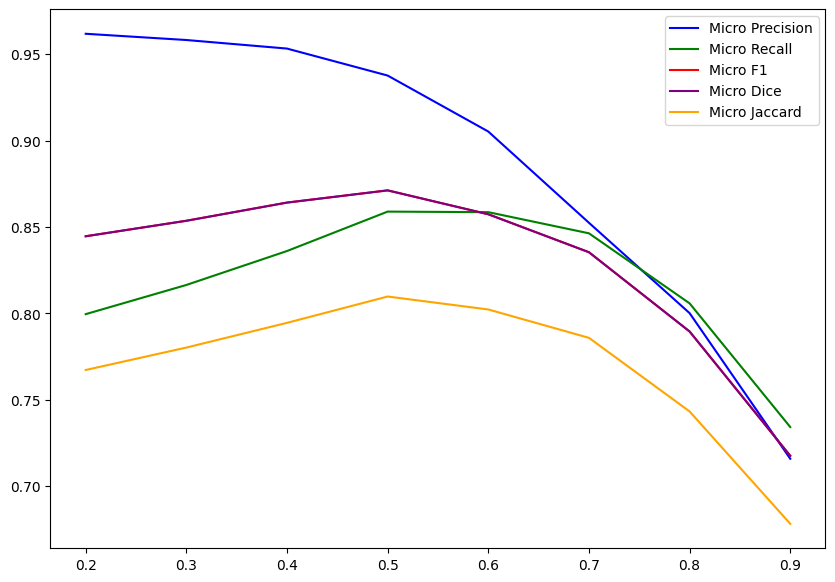

In [ ]:
## for score_threshold_acceptance from 0.5 to 0.95 step 0.05, plot precision, recall, f1, dice, jaccard for micro and macro
score_thresh_sweep = np.arange(0.2, 1.0, 0.1).round(2).tolist()
iou_thresh = 0.5

precisions_micro, recalls_micro, f1s_micro, dices_micro, jaccards_micro = [], [], [], [], []
precisions_macro, recalls_macro, f1s_macro, dices_macro, jaccards_macro = [], [], [], [], []
for score_thresh in score_thresh_sweep:
    micro_metrics = micro_average(prediction_dict, annotation_dict, score_thresh)
    macro_metrics = macro_average(prediction_dict, annotation_dict, score_thresh, iou_thresh)
    precisions_micro.append(micro_metrics['precision'])
    recalls_micro.append(micro_metrics['recall'])
    f1s_micro.append(micro_metrics['f1'])
    dices_micro.append(micro_metrics['dice'])
    jaccards_micro.append(micro_metrics['jaccard'])
    precisions_macro.append(macro_metrics['precision'])
    recalls_macro.append(macro_metrics['recall'])
    f1s_macro.append(macro_metrics['f1'])
    dices_macro.append(macro_metrics['dice'])
    jaccards_macro.append(macro_metrics['jaccard'])



## plot precision, recall, f1, dice, jaccard for micro and macro
fig = plt.figure(figsize=(10, 7))
plt.plot(score_thresh_sweep, precisions_micro, label='Micro Precision', color='blue')
plt.plot(score_thresh_sweep, recalls_micro, label='Micro Recall', color='green')
plt.plot(score_thresh_sweep, f1s_micro, label='Micro F1', color='red')
plt.plot(score_thresh_sweep, dices_micro, label='Micro Dice', color='purple')
plt.plot(score_thresh_sweep, jaccards_micro, label='Micro Jaccard', color='orange')
plt.legend()
fig.savefig(os.path.join(output_dir, 'precision_recall_f1_dice_jaccard_micro_macro.png'), dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [ ]:
# # Step 1: Compute AP scores using COCO evaluation
# print("=" * 60)
# print("Analyzing Predictions")
# print("=" * 60)

# # Determine IoU type based on tasks
# iou_type = 'segm' if 'segmentation' in tasks else 'bbox'

# print("\n[1/6] Computing AP scores...")
# try:
#     ap_scores, coco_eval = compute_ap_scores(coco_instance_result_file, annotation_file, iou_type)
#     print("\nAP Scores:")
#     for key, value in ap_scores.items():
#         print(f"  {key}: {value:.4f}")
    
#     # Save AP scores to file
#     os.makedirs(output_dir, exist_ok=True)
#     scores_path = os.path.join(output_dir, 'ap_scores.json')
#     with open(scores_path, 'w') as f:
#         json.dump(ap_scores, f, indent=2)
#     print(f"\nAP scores saved to: {scores_path}")
# except Exception as e:
#     print(f"Error computing AP scores: {e}")
#     coco_eval = None


In [ ]:
# # Step 2: Plot PR curve
# if coco_eval is not None:
#     print("\n[2/6] Plotting PR curve...")
#     try:
#         plot_pr_curve(coco_eval, output_dir, iou_type)
#     except Exception as e:
#         print(f"Error plotting PR curve: {e}")


In [ ]:
# # Step 3: Load data
# print("\n[3/6] Loading predictions and annotations...")
# try:
#     image_info_dict, annotation_dict, prediction_dict = load_data(
#         coco_instance_result_file, annotation_file
#     )
#     print(f"Loaded {len(image_info_dict)} images, {len(prediction_dict)} with predictions")
# except Exception as e:
#     print(f"Error loading data: {e}")
#     raise


In [ ]:
# # Step 4: Plot metrics vs threshold for segmentation task
# if 'segmentation' in tasks:
#     print("\n[4/6] Computing metrics across thresholds (0.5 to 0.95)...")
#     try:
#         plot_metrics_vs_threshold(
#             image_info_dict, annotation_dict, prediction_dict, output_dir
#         )
#     except Exception as e:
#         print(f"Error plotting metrics vs threshold: {e}")
#         import traceback
#         traceback.print_exc()


In [ ]:
# # Step 5: Compute metrics for all images
# # Get all image IDs that have either predictions or annotations
# all_image_ids = set(prediction_dict.keys()) | set(annotation_dict.keys())
# all_image_ids = sorted([img_id for img_id in all_image_ids if img_id in image_info_dict])

# print(f"\n[5/6] Computing metrics for all {len(all_image_ids)} images...")

# all_metrics = []
# plot_dir = os.path.join(output_dir, 'visualizations')
# os.makedirs(plot_dir, exist_ok=True)

# # Select images for visualization (first num_images)
# images_to_visualize = all_image_ids[:num_images] if num_images > 0 else []

# # Compute metrics for all images
# for idx, img_id in enumerate(all_image_ids):
#     if img_id not in image_info_dict:
#         continue
    
#     image_info = image_info_dict[img_id]
#     preds = prediction_dict.get(img_id, [])
#     annos = annotation_dict.get(img_id, [])
    
#     image_metrics = {'image_id': img_id, 'file_name': image_info.get('file_name', '')}
    
#     # Determine if we should create visualizations for this image
#     should_plot = img_id in images_to_visualize
#     plot_path = plot_dir if should_plot else None
    
#     # Analyze bbox if requested
#     if 'bbox' in tasks:
#         bbox_metrics = analyze_bbox(
#             preds, annos, acceptance_threshold,
#             image_path if should_plot else None,
#             image_info if should_plot else None,
#             plot_path
#         )
#         image_metrics['bbox'] = bbox_metrics
    
#     # Analyze segmentation if requested
#     if 'segmentation' in tasks:
#         seg_metrics = analyze_segmentation(
#             preds, annos, acceptance_threshold,
#             image_path if should_plot else None,
#             image_info if should_plot else None,
#             plot_path
#         )
#         image_metrics['segmentation'] = seg_metrics
    
#     all_metrics.append(image_metrics)
    
#     # Progress indicator
#     if (idx + 1) % 100 == 0:
#         print(f"  Processed {idx + 1}/{len(all_image_ids)} images...")

# print(f"  Completed metrics computation for {len(all_image_ids)} images")
# if images_to_visualize:
#     print(f"  Created visualizations for {len(images_to_visualize)} images")


In [ ]:
# # Step 6: Save results and compute averages
# print(f"\n[6/6] Saving results...")
# metrics_path = os.path.join(output_dir, 'per_image_metrics.json')
# with open(metrics_path, 'w') as f:
#     json.dump(all_metrics, f, indent=2)
# print(f"  Per-image metrics saved to: {metrics_path}")

# # Compute average metrics across all images
# if all_metrics:
#     print("\n" + "=" * 60)
#     print("Average Metrics (computed over all images):")
#     print("=" * 60)
    
#     if 'bbox' in tasks:
#         bbox_metrics_list = [m['bbox'] for m in all_metrics if 'bbox' in m]
#         if bbox_metrics_list:
#             avg_bbox = {
#                 'precision': np.mean([m['precision'] for m in bbox_metrics_list]),
#                 'recall': np.mean([m['recall'] for m in bbox_metrics_list]),
#                 'f1': np.mean([m['f1'] for m in bbox_metrics_list]),
#                 'mean_iou': np.mean([m['mean_iou'] for m in bbox_metrics_list]),
#             }
#             print("\n  Bbox Metrics:")
#             for key, value in avg_bbox.items():
#                 print(f"    {key}: {value:.4f}")
            
#             # Save average bbox metrics
#             avg_bbox_path = os.path.join(output_dir, 'average_bbox_metrics.json')
#             with open(avg_bbox_path, 'w') as f:
#                 json.dump(avg_bbox, f, indent=2)
    
#     if 'segmentation' in tasks:
#         seg_metrics_list = [m['segmentation'] for m in all_metrics if 'segmentation' in m]
#         if seg_metrics_list:
#             avg_seg = {
#                 'precision': np.mean([m['precision'] for m in seg_metrics_list]),
#                 'recall': np.mean([m['recall'] for m in seg_metrics_list]),
#                 'f1': np.mean([m['f1'] for m in seg_metrics_list]),
#                 'dice': np.mean([m['dice'] for m in seg_metrics_list]),
#                 'jaccard': np.mean([m['jaccard'] for m in seg_metrics_list]),
#             }
#             print("\n  Segmentation Metrics:")
#             for key, value in avg_seg.items():
#                 print(f"    {key}: {value:.4f}")
            
#             # Save average segmentation metrics
#             avg_seg_path = os.path.join(output_dir, 'average_segmentation_metrics.json')
#             with open(avg_seg_path, 'w') as f:
#                 json.dump(avg_seg, f, indent=2)

# if images_to_visualize:
#     print(f"\nVisualizations saved to: {plot_dir}")
#     print(f"  (Visualized {len(images_to_visualize)} out of {len(all_image_ids)} images)")

# print("\n" + "=" * 60)
# print("Analysis Complete!")
# print("=" * 60)
